In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def calculated_masked_attention(
    values: torch.Tensor,
    keys: torch.Tensor,
    queries: torch.Tensor,
    mask: torch.Tensor = None,
):
    
    attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
    attention_scores = attention_scores / math.sqrt(keys.shape[-1])
    if mask is not None:
        attention_scores = torch.where(mask == 0, -1e9, attention_scores)
    
    attention_scores = F.softmax(attention_scores, dim=-1)
    attention_output = torch.matmul(attention_scores, values)
    return attention_output, attention_scores

In [3]:
class FeedForward(nn.Module):
    def __init__(self, embed_size:int):
        super().__init__()
        self.fc1 = nn.Linear(embed_size, embed_size)
        self.fc2 = nn.Linear(embed_size, embed_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class AttentionLayer(nn.Module):
    def __init__(self, embed_size:int):
        super().__init__()
        self.embed_size = embed_size
        self.query_dense = nn.Linear(embed_size, embed_size)
        self.key_dense = nn.Linear(embed_size, embed_size)
        self.value_dense = nn.Linear(embed_size, embed_size)

    def forward(self, embeddings: torch.Tensor):
        query = self.query_dense(embeddings)
        key = self.key_dense(embeddings)
        value = self.value_dense(embeddings)
        attention_output, attention_scores = calculated_masked_attention(value, key, query, None)
        return attention_output, attention_scores

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size:int):
        super().__init__()
        self.attention = AttentionLayer(embed_size)
        self.feed_forward = FeedForward(embed_size)
        self.norm1 = nn.LayerNorm(embed_size)
    
    def forward(self, x: torch.Tensor):
        context, attention_scores = self.attention(x)
        context = self.norm1(context)
        context = self.feed_forward(context)
        context = F.gelu(context)
        output = context + x
        return output, attention_scores

    

class Transformer(nn.Module):
    def __init__(self, embed_size:int, num_layers:int):
        super().__init__()
        self.transformer_blocks = nn.ModuleList([TransformerBlock(embed_size) for _ in range(num_layers)])

    def forward(self, x: torch.Tensor):
        attention_scores = []
        for transformer_block in self.transformer_blocks:
            x, attention_score = transformer_block(x)
            attention_scores.append(attention_score)
        return x, attention_scores
    

class SinusodialPositionalEncoding(nn.Module):
    def __init__(self, embed_size:int, max_seq_length:int):
        super().__init__()
        position = torch.arange(0, max_seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size))
        pe = torch.zeros(max_seq_length, embed_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('positional_embedding', pe)

    def forward(self, x: torch.Tensor):
        x = x + self.positional_embedding[:x.size(1), :]
        return x

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, embed_size, num_layers):
        super(VisionTransformer, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        assert image_size % patch_size == 0, "image size must be divisible by patch size"
        self.num_patches = (image_size // patch_size) ** 2
        max_seq_length = self.num_patches + 1
        
        self.positional_encoding = SinusodialPositionalEncoding(embed_size, max_seq_length=max_seq_length)
        self.patch_embed = nn.Conv2d(num_channels, embed_size, kernel_size=patch_size, stride=patch_size)

        self.cls_token_index = 0
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))

        # Remove Positional Encoding from here
        self.transformer = Transformer(embed_size, num_layers)

    def forward(self, image, return_attention_scores=False):
        # Image Shape: (Batch, Channel, Height, Width)
        batch_size = image.shape[0]

        # Patch Embedding
        x = self.patch_embed(image) # (Batch, Embed_size, Height, Width)
        x = x.flatten(2).transpose(1, 2) # (Batch, Num_patches, Embed_size)

        # Add CLS Token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.positional_encoding(x)

        # Transformer
        x, attention_scores = self.transformer(x)
        if return_attention_scores:
            return x, attention_scores
        return x
    

class VITClassifier(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, embed_size, num_layers, num_classes):
        super().__init__()
        self.vit = VisionTransformer(image_size, patch_size, num_channels, embed_size, num_layers)
        self.fc = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        x = self.vit(x)
        x = self.fc(x[:, 0, :])
        return x

In [9]:
image = torch.randn(1, 1, 28, 28).to(device)
vit = VITClassifier(image_size=28, patch_size=14, num_channels=1, embed_size=16, num_layers=4, num_classes=10).to(device)
out = vit(image)
print(out.shape)

print(f"Number of parameters: {sum(p.numel() for p in vit.parameters())}")

torch.Size([1, 10])
Number of parameters: 8906


In [12]:
vit_output, attention_maps = vit.vit(image, return_attention_scores=True)

In [13]:
vit_output[:, 0, :].shape, attention_maps[0].shape

(torch.Size([1, 16]), torch.Size([1, 5, 5]))

In [14]:
attention_maps[0][0]

tensor([[0.1632, 0.1264, 0.2044, 0.2214, 0.2846],
        [0.3147, 0.1730, 0.1658, 0.1836, 0.1630],
        [0.3410, 0.1682, 0.1456, 0.1707, 0.1746],
        [0.3780, 0.1849, 0.1534, 0.1465, 0.1372],
        [0.4212, 0.1958, 0.1333, 0.1288, 0.1208]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [15]:
# import mnist dataset
from torchvision import datasets, transforms
import numpy as np

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:34<00:00, 288kB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:03<00:00, 8.83kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [03:38<00:00, 7.55kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.04MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=0.001)

num_epochs = 10
num_steps = 0
for epoch in range(num_epochs):
    loss_history = []
    for images, labels in mnist_train:
        images = images.unsqueeze(0).to(device)
        labels = torch.tensor([labels]).to(device)

        optimizer.zero_grad()
        output = vit(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        num_steps += 1

        if num_steps % 100 == 0:
            print(f"Epoch: {epoch}, Step: {num_steps}, Loss: {np.mean(loss_history)}")
            # loss_history = []


Epoch: 0, Step: 100, Loss: 2.44937316775322
Epoch: 0, Step: 200, Loss: 2.362836824655533
Epoch: 0, Step: 300, Loss: 2.238554158608119
Epoch: 0, Step: 400, Loss: 2.086329411715269
Epoch: 0, Step: 500, Loss: 1.9571795706748962
Epoch: 0, Step: 600, Loss: 1.8815239857758086
Epoch: 0, Step: 700, Loss: 1.8163862074592283
Epoch: 0, Step: 800, Loss: 1.7347509514726698
Epoch: 0, Step: 900, Loss: 1.6803483910734456
Epoch: 0, Step: 1000, Loss: 1.6276339138187468
Epoch: 0, Step: 1100, Loss: 1.5874664928188378
Epoch: 0, Step: 1200, Loss: 1.5448862079298125
Epoch: 0, Step: 1300, Loss: 1.5225120379360249
Epoch: 0, Step: 1400, Loss: 1.4850412302530769
Epoch: 0, Step: 1500, Loss: 1.455306849098454
Epoch: 0, Step: 1600, Loss: 1.425697583659785
Epoch: 0, Step: 1700, Loss: 1.3865085103779156
Epoch: 0, Step: 1800, Loss: 1.3377428668157922
Epoch: 0, Step: 1900, Loss: 1.3183462223175324
Epoch: 0, Step: 2000, Loss: 1.2885074132969603
Epoch: 0, Step: 2100, Loss: 1.2628172013163566
Epoch: 0, Step: 2200, Loss: 1

KeyboardInterrupt: 

In [20]:
for images, labels in mnist_test:
    images = images.unsqueeze(0).to(device)
    labels = torch.tensor([labels]).to(device)

    output = vit(images)
    pred = torch.argmax(output, dim=1)
    print(f"Predicted: {pred.item()}, True: {labels.item()}")
    break

Predicted: 7, True: 7


# Inferece with Pytorch Lightning

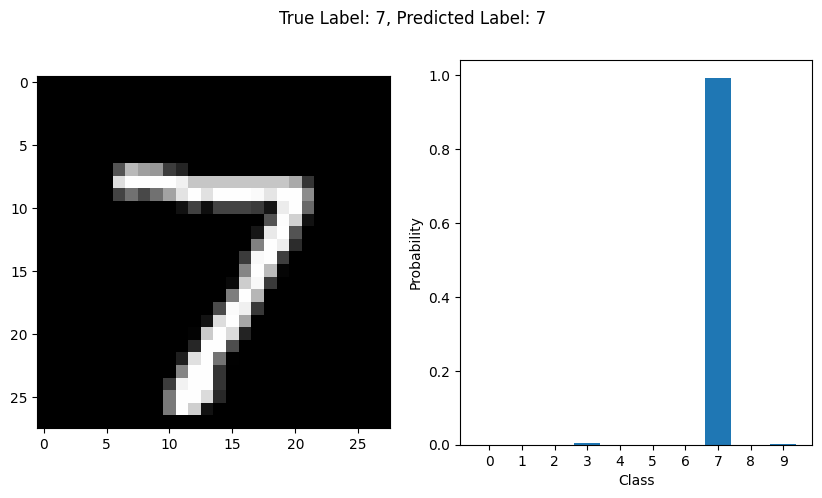

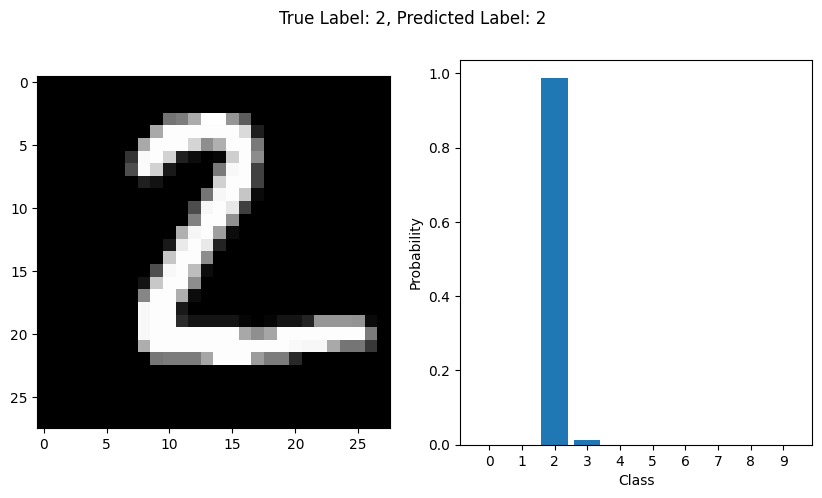

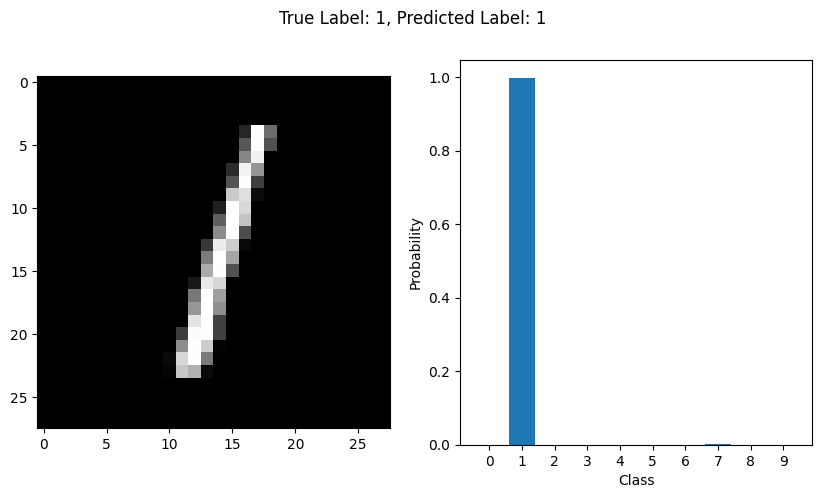

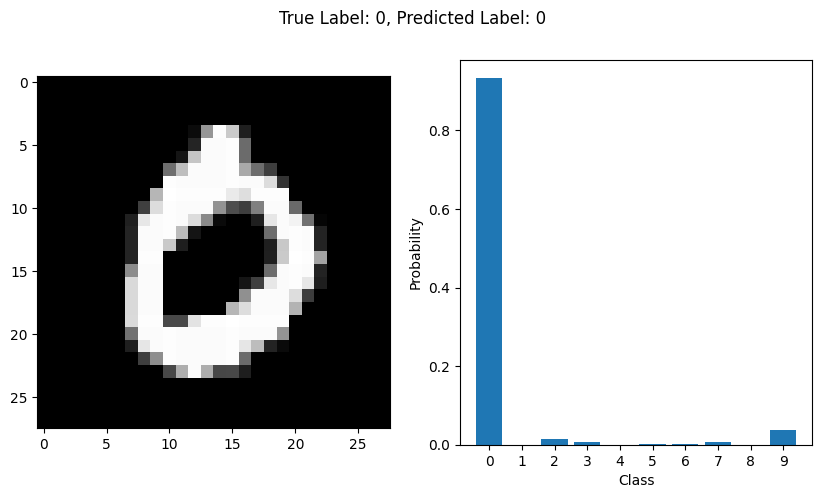

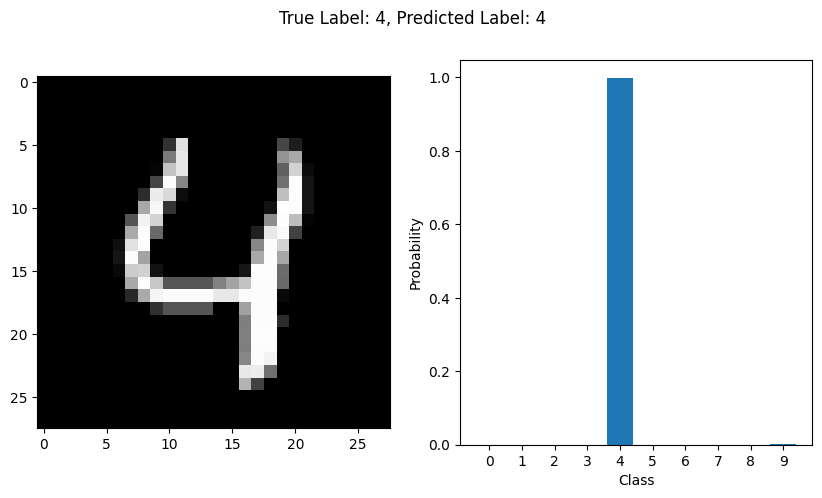

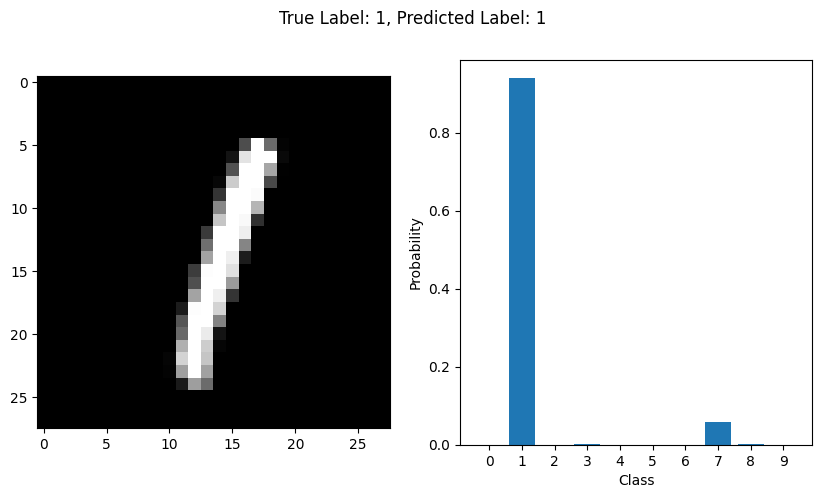

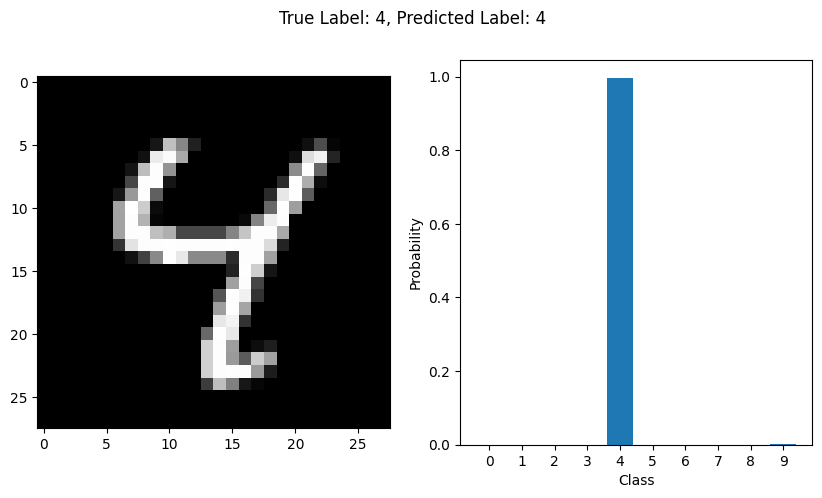

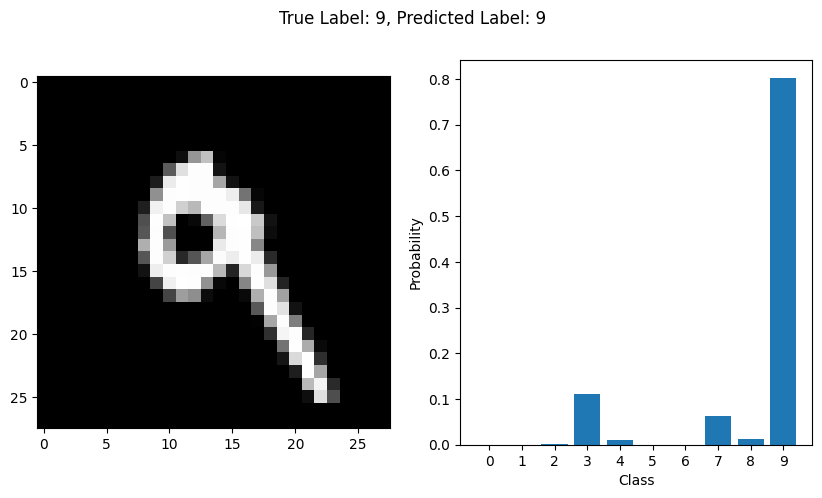

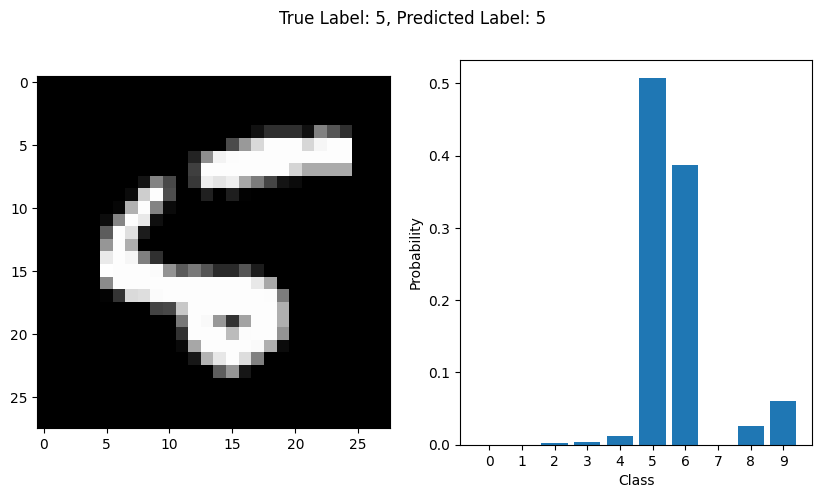

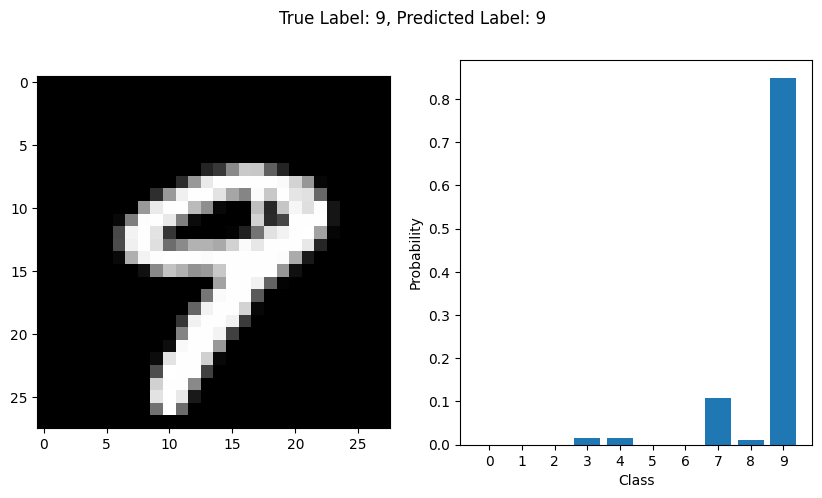

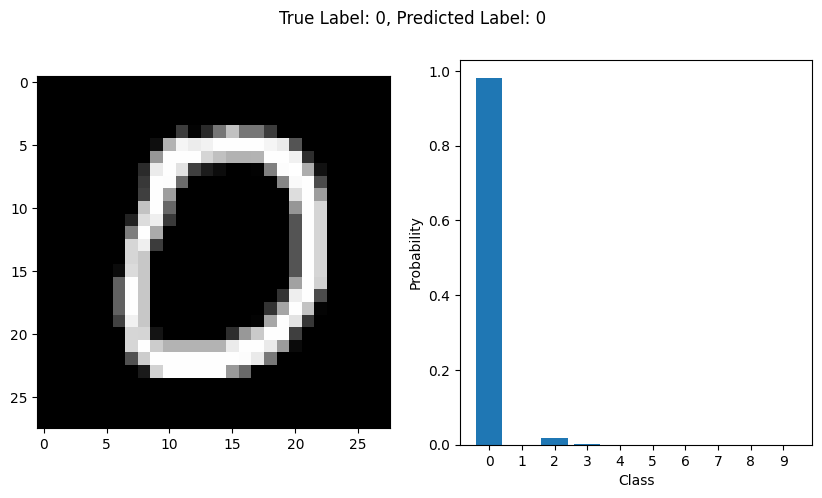

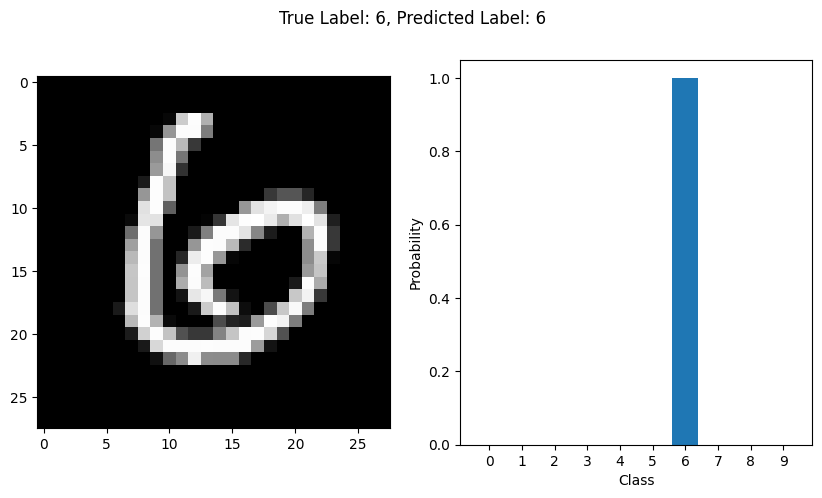

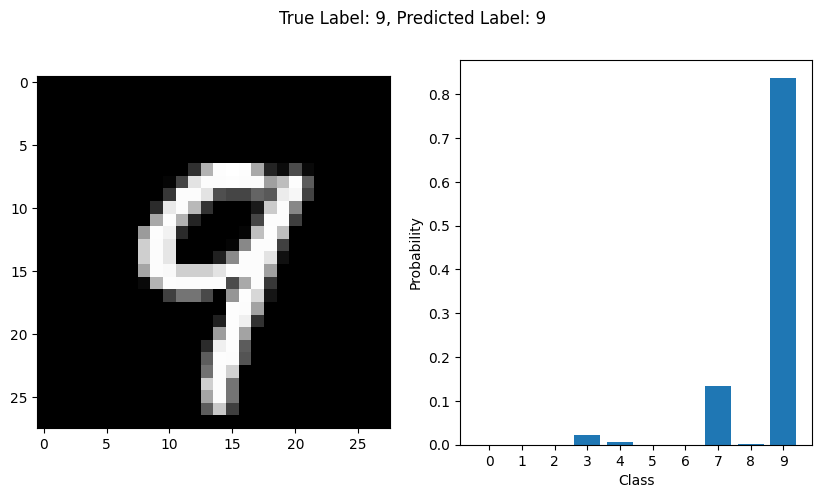

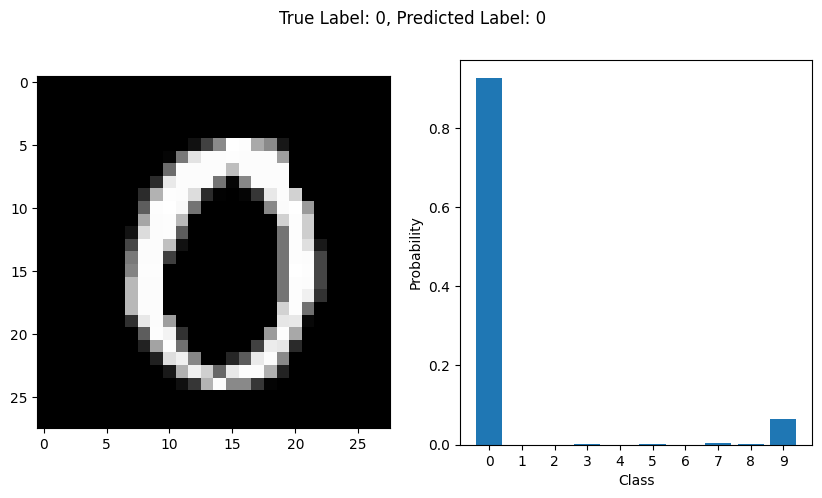

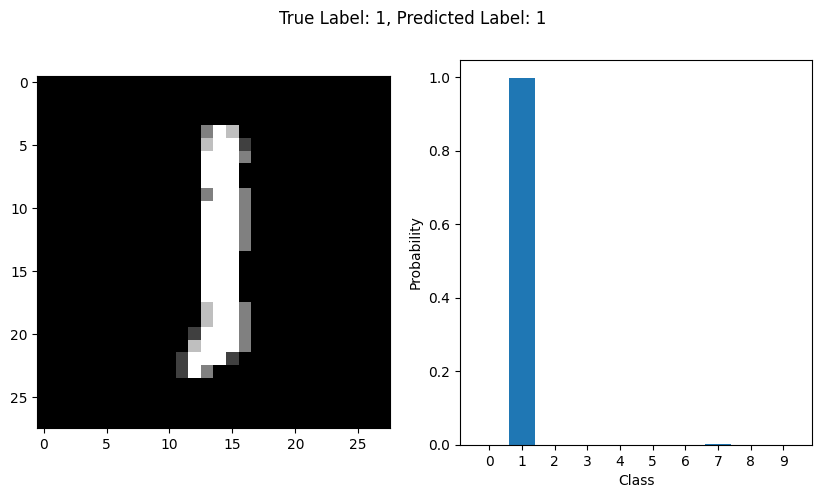

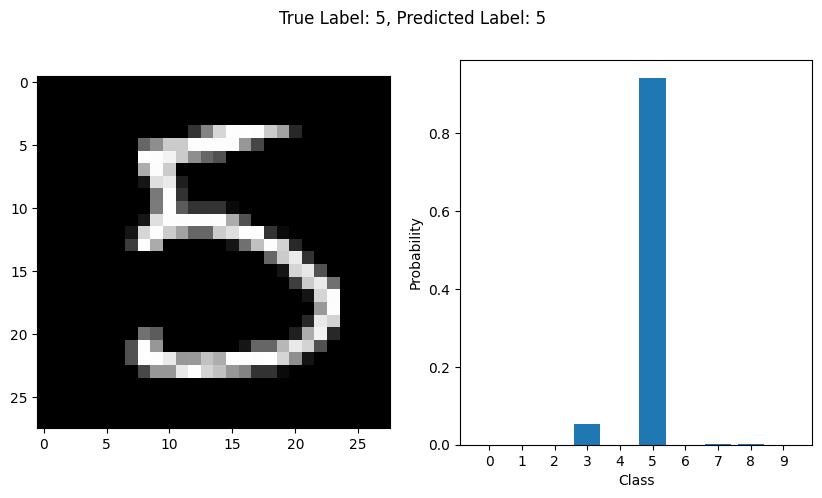

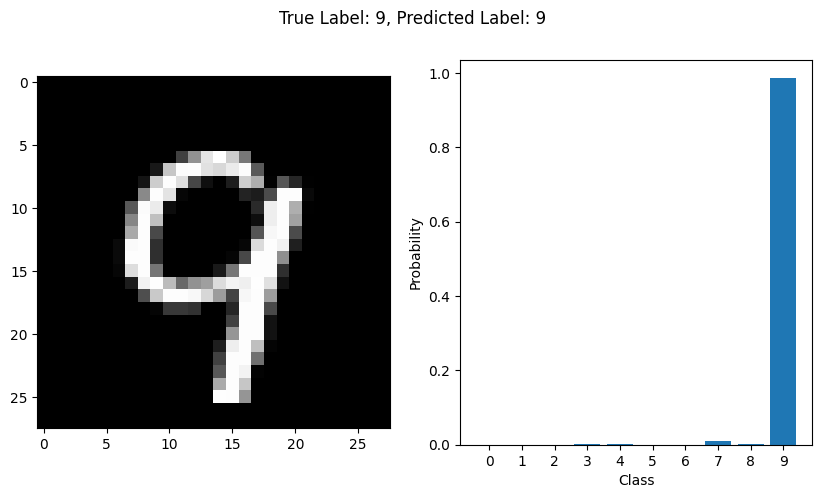

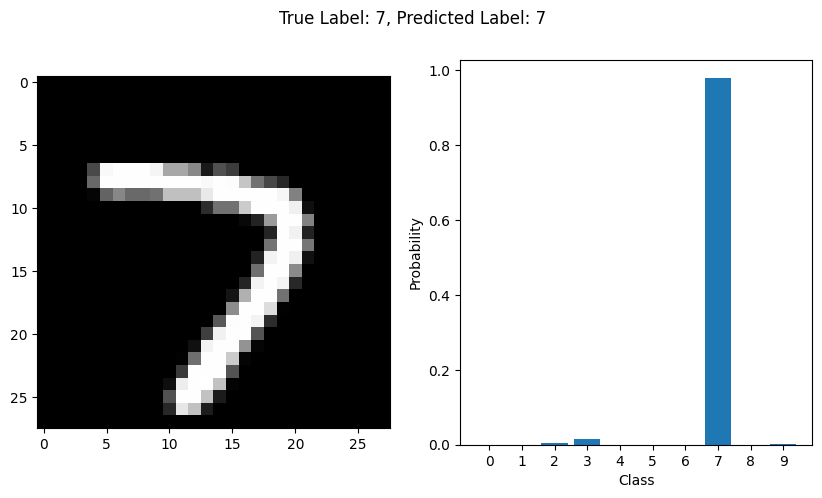

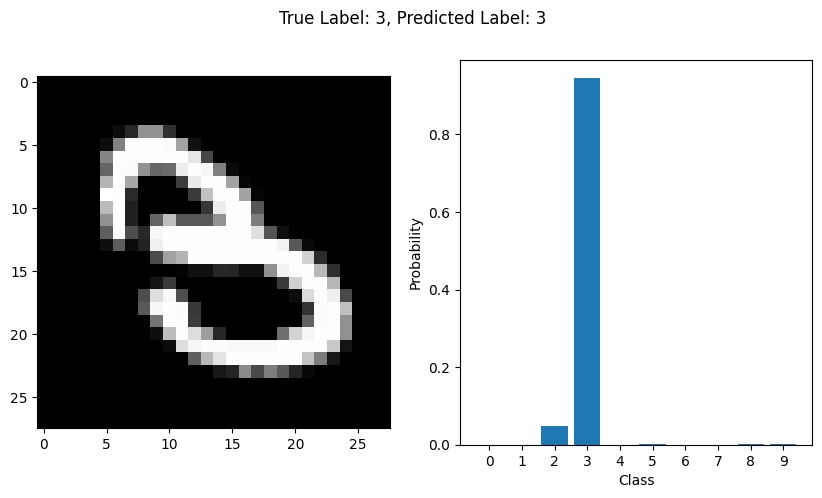

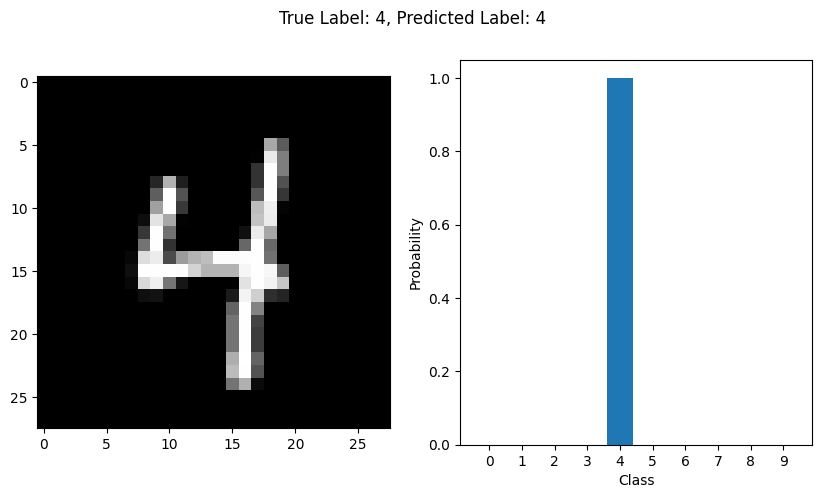

In [27]:
import matplotlib.pyplot as plt

idx = 10
for idx in range(20):
    image, label = mnist_test[idx]
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image.squeeze(0).view(28,28), cmap='gray')
    axs[1].bar(range(10), F.softmax(vit(image.unsqueeze(0).to(device)).squeeze(0), dim=0).detach().cpu().numpy())
    axs[1].set_xticks(range(10))
    axs[1].set_xlabel("Class")
    axs[1].set_ylabel("Probability")
    plt.suptitle(f"True Label: {label}, Predicted Label: {torch.argmax(vit(image.unsqueeze(0).to(device)).squeeze(0)).item()}")
    plt.show()


In [30]:
import matplotlib.pyplot as plt

def annotate_patches_with_attention(patches, att, num_patches_x, num_patches_y):
    if patches.ndim == 3:
        patches = np.repeat(patches[:, :, np.newaxis], 3, axis=-1)

    fig, axs = plt.subplots(num_patches_x, num_patches_y, figsize=(4, 4))
    top_3_idxs = np.argsort(att.flatten())[-3:]
    top_3_idxs = [i for i in top_3_idxs if att[i]>0.1]
    for i in range(num_patches_x):
        for j in range(num_patches_y):
            idx = i*num_patches_y + j
            if idx in top_3_idxs:
                img_to_draw = patches[idx]
                # Assuming img_to_draw is already 3D with shape (dim1, dim2, dim3)
                img_to_draw = np.pad(img_to_draw, ((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
                img_to_draw[0, :, :] = [0, 1, 0] # Top Border
                img_to_draw[-1, :, :] = [0, 1, 0] # Bottom Border
                img_to_draw[:, 0, :] = [0, 1, 0] # Left Border
                img_to_draw[:, -1, :] = [0, 1, 0] # Right Border

            else:
                img_to_draw = patches[idx]

            axs[i, j].imshow(img_to_draw)
            axs[i, j].annotate(f"{att[idx]:.2f}", (0, 0), xycoords='axes fraction', textcoords='offset points', va='center', ha='center', color='white', fontsize=8, bbox=dict(facecolor='blue', alpha=0.7, edgcolor='none', pad=2))
            axs[i, j].axis('off')

    return fig


def draw_multiple_attention_maps(patches, att, num_rows=None, labels=None, figsize=(16,16)):
    num_heads = att.shape[0]
    if num_rows is None:
        num_rows = 2

    num_cols = num_heads // num_rows
    if labels is None:
        labels = [f"Head {i+1}" for i in range(num_heads)]

    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    axs = axs.flatten()
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i*num_cols + j
            ax = axs[idx]
            subfig = annotate_patches_with_attention(patches, att[idx])

            # convert subfig to image
            subfig.canvas.draw()
            img = np.array(subfig.canvas.renderer.buffer_rgba())
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(labels[idx])

            plt.close(subfig)

    plt.tight_layout()
    plt.show()


def get_patches_and_attention_maps(img_list, attention_map_cls, patch_size, num_patches_x, num_patches_y):
    image = img_list.view(28, 28).detach().cpu().numpy()
    att = attention_map_cls.detach().cpu().numpy()
    patches = np.array([image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] for i in range(num_patches_x) for j in range(num_patches_y)])

In [ ]:
idx = 10
num_patches_x = 28 // 14
num_patches_y = 28 // 14
patches, att = get_patches_and_attention_maps(mnist_test[idx][0], attention_maps[0][0], 14, num_patches_x, num_patches_y)